In [4]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import random

In [5]:
# Define the root directories for training and testing
train_dir = 'C:/Users/denis/Desktop/HNS/projekt1/Dataset_Znacky/Train-adj-train-test/train'
test_dir = 'C:/Users/denis/Desktop/HNS/projekt1/Dataset_Znacky/Train-adj-train-test/test'

# Create a list of unique class labels for training data
unique_labels_train = sorted(os.listdir(train_dir))

# Create a mapping from class labels to sequential integers for training data
label_to_int_train = {label: i for i, label in enumerate(unique_labels_train)}

# Create a list of unique class labels for test data
unique_labels_test = sorted(os.listdir(test_dir))

# Create a mapping from class labels to sequential integers for test data
label_to_int_test = {label: i for i, label in enumerate(unique_labels_test)}

# Define transforms for data augmentation and normalization
data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
# Define your custom dataset
class CustomDataset(Dataset):
    def __init__(self, data_dir, label_to_int, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.samples = []

        for class_name in os.listdir(data_dir):
            class_dir = os.path.join(data_dir, class_name)

            if os.path.isdir(class_dir):
                images = os.listdir(class_dir)
                random.shuffle(images)

                for img in images:
                    image_path = os.path.join(class_dir, img)
                    label = label_to_int[class_name]
                    self.samples.append((image_path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        return image, label

# Create custom datasets for training and testing
train_dataset = CustomDataset(train_dir, label_to_int_train, data_transforms)
test_dataset = CustomDataset(test_dir, label_to_int_test, data_transforms)

# Create data loaders for training and testing
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Load a pretrained GoogLeNet model
model = models.googlenet(pretrained=True)

# Freeze all the layers in the model
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the final fully connected layer so it can be trained
# Replace the last layer with a new layer with the correct number of outputs
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(unique_labels_train)) 

In [7]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


Epoch 1/20, Training Loss: 1.8614959076598838, Validation Loss: 1.5024966716766357
Epoch 2/20, Training Loss: 1.3926467167006598, Validation Loss: 1.2567295363074855
Epoch 3/20, Training Loss: 1.2245409324686363, Validation Loss: 1.1321378751804954
Epoch 4/20, Training Loss: 1.138244334036711, Validation Loss: 1.0465477077584517
Epoch 5/20, Training Loss: 1.0837891191717177, Validation Loss: 1.0141307783754248
Epoch 6/20, Training Loss: 1.0429890316630166, Validation Loss: 0.9634079857876426
Epoch 7/20, Training Loss: 1.0286591251691182, Validation Loss: 0.9463271150463506
Epoch 8/20, Training Loss: 1.000589883359021, Validation Loss: 0.9134637995770103
Epoch 9/20, Training Loss: 0.9809507073233368, Validation Loss: 0.8898543922524703
Epoch 10/20, Training Loss: 0.9488469822696908, Validation Loss: 0.8859886341973355
Epoch 11/20, Training Loss: 0.9504927163401609, Validation Loss: 0.8732295735886223
Epoch 12/20, Training Loss: 0.9396441701858763, Validation Loss: 0.8581231481150577
Epo

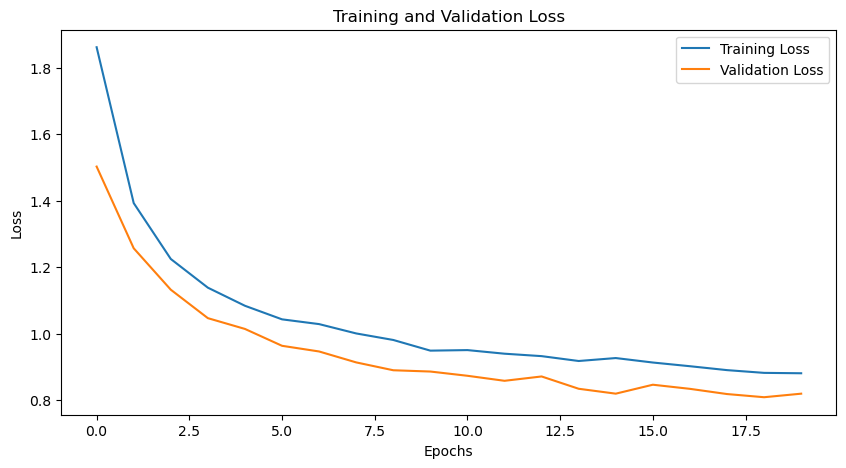

In [8]:
# Set the loss function and optimizer
import torch.optim as optim
import torch
import matplotlib.pyplot as plt

# Assuming you've already defined your model, criterion, train_loader, and test_loader

# Set the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, momentum=0.9)

# Choose the right device based on availability of CUDA
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
num_epochs = 20
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_running_loss = 0.0
    with torch.no_grad():  # Gradient computation is not needed for validation
        for val_inputs, val_labels in test_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            val_running_loss += val_loss.item()
    
    val_loss = val_running_loss / len(test_loader)
    val_losses.append(val_loss)

    # Print losses
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_loss}, Validation Loss: {val_loss}")

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()





In [9]:
# Test the model on the testing data
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 71.67%
